In [1]:
from dotenv import load_dotenv

load_dotenv()

import os

# 프로젝트 설정
new_project_name = "MTVS-project4"
os.environ["LANGSMITH_PROJECT"] = new_project_name

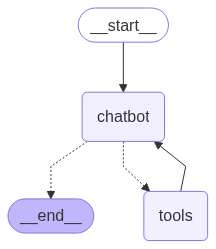

In [26]:
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)

# 1. tool 세팅
search_tool = DuckDuckGoSearchResults(
    llm=llm,
    max_results=3,  # 최대 검색 결과 수
    description="한글 단어의 유사어나 신조어를 검색합니다.",
    return_direct=False,
)
tools = [search_tool]


# 2. State 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 3. LLM + 툴 바인딩
llm_with_tools = llm.bind_tools(tools)


# 4. chatbot 노드 정의
def agent_chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    return {"messages": [answer]}  # 자동으로 add_messages 적용


# 5. 그래프 초기화 & 노드 추가
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", agent_chatbot)


# 6. 도구 노드 생성
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)


# 7. 조건부 엣지 설정
graph_builder.add_conditional_edges(
    source="chatbot",
    path=tools_condition,
    path_map={"tools": "tools", END: END},
)


# 8. 툴 -> 챗봇, START -> 챗봇 엣지 추가
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


# 9. 그래프 컴파일
graph = graph_builder.compile()
graph

In [ ]:
from opensearchpy import OpenSearch
from app.sbert_model import SBERTEmbedder

SIMILARITY_THRESHOLD = 0.8  # cosineSimilarity + 1.0 = 1.5를 넘도록 기준 설정

client = OpenSearch(hosts=[{"host": "localhost", "port": 9200}])
embedder = SBERTEmbedder()


def check_rag_function(state):
    query = state["query"]
    vector = embedder.encode([query])[0]

    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, doc['embedding']) + 1.5",
                "params": {"query_vector": vector.tolist()},
            },
        }
    }

    response = client.search(
        index="korean-english-dictionary", body={"query": script_query}
    )
    hits = response["hits"]["hits"]

    if not hits:
        return {"query": query, "retrieved": [], "missing_count": 5}

    top_sentences = [
        hit["_source"]["form"]
        for hit in hits
        if (hit["_score"] - 1.5) > SIMILARITY_THRESHOLD
    ]

    missing_count = max(0, 5 - len(top_sentences))

    return {
        "query": query,
        "retrieved": top_sentences,
        "missing_count": missing_count,
    }

In [ ]:
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage

# 설정
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
ddg_tool = DuckDuckGoSearchResults(search_engine=DuckDuckGoSearchRun(), llm=llm)


def web_or_llm_merge_function(state):
    query = state["query"]
    existing = state.get("retrieved", [])
    need = state.get("missing_count", 5)

    # 웹 검색 (예: DuckDuckGo)
    web_results = [f"{query} 웹유사어{i+1}" for i in range(need // 2)]

    # LLM 생성
    llm_response = llm(
        [HumanMessage(content=f"'{query}'와 관련된 유사 단어 {need}개 생성해줘.")]
    )
    llm_results = llm_response.content.strip().splitlines()

    # 병합 및 중복 제거
    all_results = list(dict.fromkeys(existing + web_results + llm_results))[:5]

    return {"final_results": all_results}

In [38]:
from langgraph.graph import StateGraph
from langgraph.graph.graph import START, END

builder = StateGraph(dict)

# ✅ check_rag 노드
builder.add_node("check_rag", check_rag_function)


def route(state):
    if state.get("missing_count", 5) == 0:
        return "return_result"
    return "search_or_generate"


builder.add_conditional_edges(
    "check_rag", route, {"return_result": END, "search_or_generate": "web_or_llm"}
)

builder.add_node("web_or_llm", web_or_llm_merge_function)
builder.add_edge("web_or_llm", END)
builder.add_edge(START, "check_rag")

graph = builder.compile()

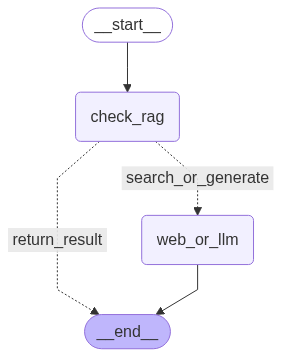

In [39]:
graph

In [1]:
from opensearchpy import OpenSearch
from app.sbert_model import SBERTEmbedder
from langchain_openai import ChatOpenAI

SIMILARITY_THRESHOLD = 0.8  # cosineSimilarity + 1.0 = 1.5를 넘도록 기준 설정

client = OpenSearch(hosts=[{"host": "localhost", "port": 9200}])
embedder = SBERTEmbedder()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
)


def check_rag_function(state):
    query = state["query"]
    vector = embedder.encode([query])[0]

    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, doc['embedding']) + 1.5",
                "params": {"query_vector": vector.tolist()},
            },
        }
    }

    response = client.search(
        index="korean-english-dictionary", body={"query": script_query}
    )
    hits = response["hits"]["hits"]

    if not hits:
        return {"query": query, "retrieved": [], "missing_count": 5}

    top_sentences = [
        hit["_source"]["form"]
        for hit in hits
        if (hit["_score"] - 1.5) > SIMILARITY_THRESHOLD
    ]

    missing_count = max(0, 5 - len(top_sentences))
    missing_web = 0
    missing_llm = 0
    if missing_count % 2 == 1:
        missing_llm = missing_count // 2 + 1
        missing_web = missing_count // 2
    else:
        missing_llm = missing_count // 2
        missing_web = missing_count // 2
    return {
        "query": query,
        "retrieved": top_sentences,
        "missing_web": missing_web,
        "missing_llm": missing_llm
    }

c:\Users\hwan7\.conda\envs\project4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
check_rag_function({"query": "사랑"})

Batches: 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]


{'query': '사랑',
 'retrieved': ['사랑', '사랑', '사랑하다'],
 'missing_web': 1,
 'missing_llm': 1}

In [17]:
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_core.messages import HumanMessage 

def web_search_node(state: dict) -> dict:
    print(f"--- DEBUG: web_search_node ---")
    print(f"Input state type: {type(state)}")
    print(f"Input state content: {state}")

    query = state["query"]
    num_to_find_from_web = state.get("missing_web", 0)

    final_web_words = []

    if num_to_find_from_web > 0:
        search_tool = DuckDuckGoSearchResults(
            max_results=max(5, num_to_find_from_web * 2),
        )

        try:
            search_output = search_tool.run(f"'{query}'와 가장 유사한 단어 또는 관련된 핵심 단어 {num_to_find_from_web}개")

            search_results_list = []
            if isinstance(search_output, str):
                search_results_list = [s.strip() for s in search_output.split("\n") if s.strip()]
            elif isinstance(search_output, list):
                search_results_list = search_output
            else:
                print(f"Web Search: Unexpected type from search_tool.run(): {type(search_output)}")

            if search_results_list:
                context_for_llm = "\n".join(search_results_list[:5]) # 상위 5개 검색 결과 요약을 컨텍스트로
                if context_for_llm:
                    prompt_content = (
                        f"다음은 '{query}'와(과) 관련된 웹 검색 결과입니다:\n---CONTEXT_START---\n{context_for_llm}\n---CONTEXT_END---\n\n"
                        f"이 정보를 바탕으로 '{query}'와(과) 의미적으로 유사하거나 관련된 핵심 단어를 정확히 {num_to_find_from_web}개 찾아주세요. "
                        f"결과는 반드시 콤마(,)로 구분된 단어 목록으로만 응답해주세요. "
                        f"다른 어떤 설명, 번호 매기기, 문장, 줄바꿈도 포함하지 마세요. "
                        f"오직 단어들만 콤마로 구분해서 한 줄로 응답해야 합니다."
                    )
                    response = llm.invoke([HumanMessage(content=prompt_content)]) # llm 객체 사용
                    response_text = response.content.strip()
                    if response_text:
                        final_web_words = [word.strip() for word in response_text.split(',') if word.strip() and word.strip().lower() != query.lower()]
                        final_web_words = final_web_words[:num_to_find_from_web] # 정확히 목표 개수만큼만

        except Exception as e:
            print(f"Error during web search or LLM processing in web_search_node: {e}")
            # final_web_words는 빈 리스트로 유지됨
    else:
        print("Web Search: Skipping web search as missing_web is 0.")

    # 웹 검색 후 LLM이 최종적으로 찾아야 할 단어 수 다시 계산
    # (check_rag에서 설정된 missing_llm 값에서, 웹에서 찾은 만큼을 제외)
    # 하지만, check_rag에서 missing_llm과 missing_web을 이미 분배했으므로,
    # 웹에서 찾은 단어 수와 관계없이 llm_generate_node는 원래 할당된 missing_llm만큼 생성해야 함.
    # 따라서, missing_llm 값을 여기서 변경하지 않고 그대로 전달하거나,
    # 또는, check_rag_function에서 missing_count 전체를 전달하고,
    # web_search_node에서 웹 검색 후 남은 missing_count를 missing_llm으로 설정하는 방식도 가능.
    # 현재 check_rag_function의 로직을 따르면, missing_llm은 변경하지 않는 것이 맞음.

    output_dict = {
        "query": query,  # 이전 상태의 query 유지
        "retrieved": state.get("retrieved", []),  # RAG 결과 유지
        "missing_web": state.get(
            "missing_web", 0
        ),  # 필요하다면 이 값은 0으로 업데이트 가능
        "missing_llm": state.get(
            "missing_llm", 0
        ),  # llm_generate_node가 사용할 값 유지
        "web_search_results": final_web_words,  # 현재 노드에서 생성된 결과 추가
    }

    return output_dict

In [18]:
def llm_generate_node(state):  # llm 인스턴스를 전달받도록 수정
    print(f"--- DEBUG: llm_generate_node ---")
    print(f"Input state type: {type(state)}")
    print(f"Input state content: {state}") # 여기서 'query' 키가 있는지 확인!
    
    if "query" not in state:
        print("ERROR: 'query' key is missing in state at llm_generate_node!")
        # 여기서 에러를 발생시키거나, 기본값을 사용하거나, 이전 노드의 문제임을 인지할 수 있습니다.
        # 임시로 빈 query를 사용하거나, 예외를 발생시켜 디버깅을 계속할 수 있습니다.
        # raise KeyError("'query' not found in state for llm_generate_node") 
        query = "기본값_쿼리_없음" # 또는 빈 문자열
    else:
        query = state["query"]
        
    # missing_count = state.get("missing_llm", 0)
    # ... (나머지 로직) ...
    query = state["query"]
    n = state.get("missing_llm", 0)
    if n == 0:
        return {"llm_results": []}

    # 프롬프트 수정:
    prompt_content = (
        f"'{query}'와(과) 관련된 유사 단어 정확히 {n}개를 찾아주세요. "
        f"결과는 반드시 콤마(,)로 구분된 단어 목록으로만 응답해주세요. "
        f"다른 어떤 설명, 번호 매기기, 문장, 줄바꿈도 포함하지 마세요. "
        f"오직 단어들만 콤마로 구분해서 한 줄로 응답해야 합니다. "
        f"예시 (만약 {n}=3이고 query가 '행복'이라면): 기쁨,즐거움,만족"
    )

    response = llm.invoke([HumanMessage(content=prompt_content)])
    response_text = response.content.strip()
    if not response_text:  # 빈 문자열 응답 시
        results = []
    else:
        # 콤마로 분리하고, 각 단어의 앞뒤 공백 제거
        results = [word.strip() for word in response_text.split(",") if word.strip()]

    return {"llm_results": results[:n]}  

In [19]:
def merge_node(state):
    retrieved = state.get("retrieved", [])
    web = state.get("web_results", [])
    llm = state.get("llm_results", [])

    final = list(dict.fromkeys(retrieved + web + llm))[:5]
    return {"final_results": final}

In [20]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(dict)

builder.add_node("check_rag", check_rag_function)


def route(state):
    if state.get("missing_web", 0) == 0 and state.get("missing_llm", 0) == 0:
        return "enough"
    return "search_needed"


builder.add_conditional_edges(
    "check_rag", route, {"enough": END, "search_needed": "web_search"}
)

builder.add_node("web_search", web_search_node)
builder.add_node("llm_generate", llm_generate_node)
builder.add_node("merge", merge_node)

builder.add_edge(START, "check_rag")
builder.add_edge("web_search", "llm_generate")
builder.add_edge("llm_generate", "merge")
builder.add_edge("merge", END)

graph = builder.compile()

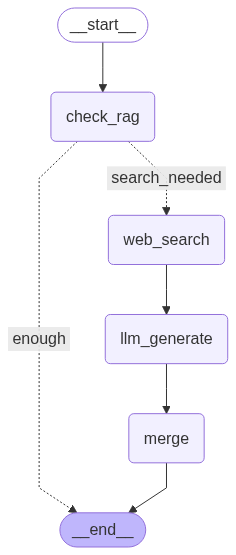

In [21]:
graph

In [22]:
result = graph.invoke({"query": "사랑"})
print("최종 유사어:", result)

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


--- DEBUG: web_search_node ---
Input state type: <class 'dict'>
Input state content: {'query': '사랑', 'retrieved': ['사랑', '사랑', '사랑하다'], 'missing_web': 1, 'missing_llm': 1}
--- DEBUG: llm_generate_node ---
Input state type: <class 'dict'>
Input state content: {'query': '사랑', 'retrieved': ['사랑', '사랑', '사랑하다'], 'missing_web': 1, 'missing_llm': 1, 'web_search_results': ['애정']}
최종 유사어: {'final_results': ['애정']}


In [23]:
result = graph.invoke({"query": "플러팅"})
print("최종 유사어:", result)

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


--- DEBUG: web_search_node ---
Input state type: <class 'dict'>
Input state content: {'query': '플러팅', 'retrieved': [], 'missing_web': 2, 'missing_llm': 3}
--- DEBUG: llm_generate_node ---
Input state type: <class 'dict'>
Input state content: {'query': '플러팅', 'retrieved': [], 'missing_web': 2, 'missing_llm': 3, 'web_search_results': ['관심', '매력']}
최종 유사어: {'final_results': ['유혹', '애정', '사랑']}
